# **keras-tuner**


## 1.환경준비

### (1) 라이브러리 로딩

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True) # 반올림해 소수점 3째자리까지 표시하며, 작은 수를 지수형식이 아닌 일반적인 형식으로 출력하도록

In [ ]:
from keras.layers import Dense, Conv2D, MaxPool2D, Conv1D, MaxPool1D, Normalization, Reshape, Flatten
from keras.models import Sequential
from keras.backend import clear_session
from keras.optimizers import Adam
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(hist['loss'], marker = '.', label = 'train_acc')
    plt.plot(hist['val_loss'], marker = '.', label = 'val_acc')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터셋 : Auto MPG
중고차 연비 예측

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

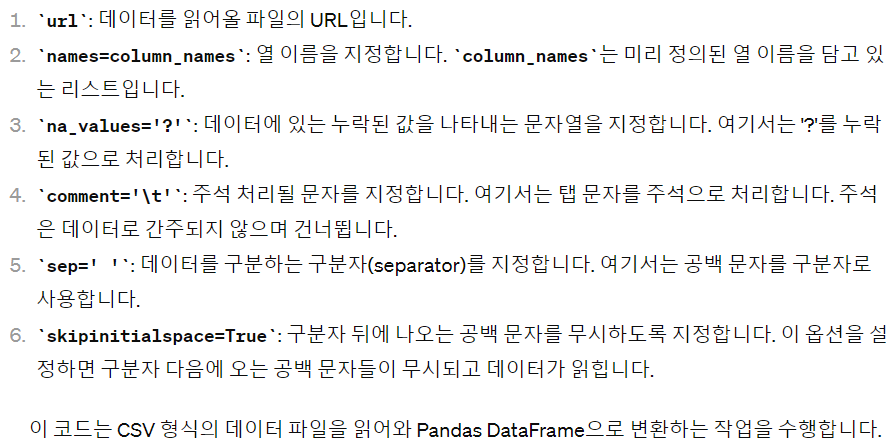

In [ ]:
data = raw_dataset.copy()
data.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## 2.데이터 전처리

### (1) 결측치 조치

In [ ]:

data.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

이 초기 튜토리얼을 간단하게 유지하려면 해당 행을 삭제하세요.

In [ ]:
data = data.dropna()

In [ ]:
data.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

### (2) 가변수화

In [ ]:
data['Origin'] = data['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [ ]:
data = pd.get_dummies(data, columns=['Origin'], prefix='', prefix_sep='') # 열이름 깔끔하게
data.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### (3) 데이터셋 분할

In [ ]:
train = data.sample(frac=0.8, random_state=0) # 80%의 랜덤한 행 선택
test = data.drop(train.index)

전체 통계도 확인해보겠습니다. 각 특성이 매우 다른 범위를 포괄하고 있는 것에 주목하세요.

In [ ]:
x_train = train.copy()
x_test = test.copy()

y_train = x_train.pop('MPG')
y_test = x_test.pop('MPG')

### (4) 스케일링

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## 3.모델링1 : base line

선형회귀 모델

In [ ]:
clear_session()
model1 = Sequential([Dense(1, input_shape = (x_train.shape[1],))])

model1.compile(loss='mean_absolute_error', optimizer=Adam(0.1))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 10 (40.00 Byte)
Trainable params: 10 (40.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%%time
# 셀 실행하는 데 걸린 시간 출력
hist = model1.fit(x_train, y_train, validation_split=0.2, verbose=0, epochs=100).history

KeyboardInterrupt: 

In [ ]:
dl_history_plot(hist)

MAE : 2.3848049310537487


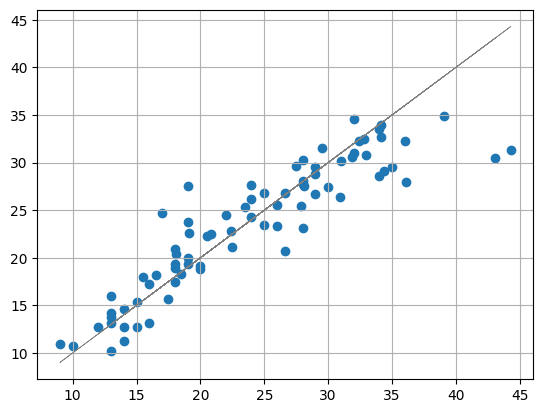

In [ ]:
pred1 = model1.predict(x_test, verbose = 0)
print('MAE :', mean_absolute_error(y_test, pred1))

plt.scatter(y_test, pred1)
plt.plot(y_test, y_test, color = 'gray', linewidth = .5) # 이 직선에 점들이 모여있을수록 성능이 좋은 모델!
plt.grid()
plt.show()

## 4.모델링2 : hyperparameter tuning

keras tuner활용

### (1) hidden layer 1개 노드 튜닝
* 튜닝 방식 : RandomSearch
* 실험 : 총 10회
    * 노드 : 8, 16, 32, 64, 128, 256
    * 학습률 : 0.0001, 0.001, 0.01

In [ ]:
# 레이어가 아닌 각 노드의 범위 지정해 각 모델 만들어 성능비교 - 그리드서치, 랜덤서치 둘다 가능

def build_model(hp): # hp는 Hyperparameter 객체
    model = Sequential([ Dense(units=hp.Choice('node1', [8, 16, 32, 64, 128, 256]),
                               input_shape = (x_train.shape[1],), activation='relu'),
                         Dense(1)])
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate = hp.Choice('learning_rate', [0.0001, 0.001, 0.01])))
    return model

In [ ]:
%%time
tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials = 10, project_name='dnn_tune_1') # max_trials는 시도할 하이퍼파라미터 조합의 총 횟수
tuner.search(x_train, y_train, epochs = 100, validation_split = .2, verbose=0)

CPU times: user 1min 9s, sys: 2.75 s, total: 1min 12s
Wall time: 1min 41s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
node1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [ ]:
tuner.results_summary()

Results summary
Results in ./dnn_tune_1
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 04 summary
Hyperparameters:
node1: 256
learning_rate: 0.01
Score: 2.041687488555908

Trial 09 summary
Hyperparameters:
node1: 64
learning_rate: 0.01
Score: 2.098809242248535

Trial 02 summary
Hyperparameters:
node1: 128
learning_rate: 0.001
Score: 2.8804142475128174

Trial 08 summary
Hyperparameters:
node1: 32
learning_rate: 0.001
Score: 3.411757707595825

Trial 06 summary
Hyperparameters:
node1: 8
learning_rate: 0.001
Score: 10.034010887145996

Trial 00 summary
Hyperparameters:
node1: 128
learning_rate: 0.0001
Score: 17.30424690246582

Trial 07 summary
Hyperparameters:
node1: 64
learning_rate: 0.0001
Score: 20.088685989379883

Trial 01 summary
Hyperparameters:
node1: 8
learning_rate: 0.0001
Score: 21.472801208496094

Trial 05 summary
Hyperparameters:
node1: 32
learning_rate: 0.0001
Score: 21.827882766723633

Trial 03 summary
Hyperparameters:
node1: 16
learning_rate: 0.0001

MAE : 2.0067680187714405


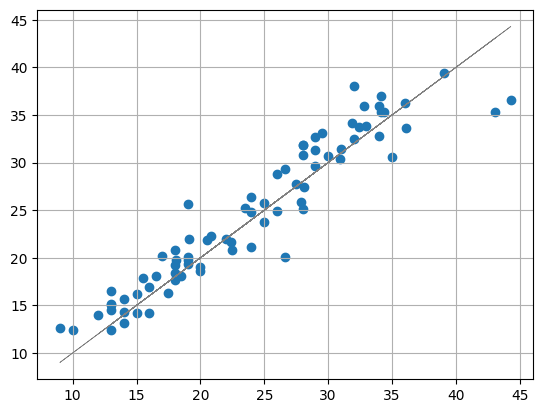

In [ ]:
# 튜닝 모델을 이용하여 예측하고 평가하기
pred2_1 = best_model.predict(x_test, verbose = 0)
print('MAE :', mean_absolute_error(y_test, pred2_1))

plt.scatter(y_test, pred2_1)
plt.plot(y_test, y_test, color = 'gray', linewidth = .5)
plt.grid()
plt.show()

### (2) hidden layer 2개 노드 튜닝
* 튜닝 방식 : GridSearch
* 실험 : 총 15회
    * 노드1 : 16, 32, 64, 128, 256
    * 노드2 : 8, 16, 32, 64,128
    * 학습률 : 0.0001, 0.001, 0.01

In [ ]:
def build_model(hp):
    n1 = hp.Choice('node1', [16, 32, 64, 128, 256])
    n2 = hp.Choice('node2', [8, 16, 32, 64, 128])
    model = Sequential([ Dense(units=n1,
                               input_shape = (x_train.shape[1],), activation='relu'),
                         Dense(units=n2,
                               activation='relu'),
                         Dense(1)])
    model.compile(loss='mean_absolute_error', optimizer=Adam(hp.Choice('learning_rate', [0.0001, 0.001, 0.01])))
    return model

In [ ]:
%%time
tuner = kt.GridSearch(build_model, objective='val_loss', project_name='dnn_tune_2') # max_trials
tuner.search(x_train, y_train, epochs = 30, validation_split = .2, verbose=0)
best_model = tuner.get_best_models(num_models=1)[0]

CPU times: user 4min 23s, sys: 8.01 s, total: 4min 31s
Wall time: 5min 15s


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
node1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256], 'ordered': True}
node2 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [ ]:
tuner.results_summary()

Results summary
Results in ./dnn_tune_2
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0074 summary
Hyperparameters:
node1: 256
node2: 128
learning_rate: 0.01
Score: 1.992384672164917

Trial 0023 summary
Hyperparameters:
node1: 32
node2: 32
learning_rate: 0.01
Score: 1.9964064359664917

Trial 0044 summary
Hyperparameters:
node1: 64
node2: 128
learning_rate: 0.01
Score: 2.0030784606933594

Trial 0059 summary
Hyperparameters:
node1: 128
node2: 128
learning_rate: 0.01
Score: 2.0116944313049316

Trial 0068 summary
Hyperparameters:
node1: 256
node2: 32
learning_rate: 0.01
Score: 2.015634298324585

Trial 0056 summary
Hyperparameters:
node1: 128
node2: 64
learning_rate: 0.01
Score: 2.026554822921753

Trial 0011 summary
Hyperparameters:
node1: 16
node2: 64
learning_rate: 0.01
Score: 2.0316383838653564

Trial 0038 summary
Hyperparameters:
node1: 64
node2: 32
learning_rate: 0.01
Score: 2.036803960800171

Trial 0050 summary
Hyperparameters:
node1: 128
node2: 16
learning

MAE : 1.9720865909869854


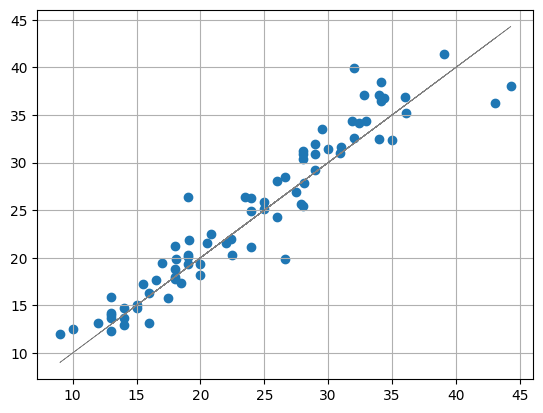

In [ ]:
pred2_2 = best_model.predict(x_test, verbose = 0)
print('MAE :', mean_absolute_error(y_test, pred2_2))

plt.scatter(y_test, pred2_2)
plt.plot(y_test, y_test, color = 'gray', linewidth = .5)
plt.grid()
plt.show()

### (3) hidden layer 3개 노드 튜닝
* 튜닝 방식 : GridSearch
* 실험 : 총 20회
    * 노드1 : 16, 32, 64, 128, 256
    * 노드2 : 8, 16, 32, 64,128
    * 노드3 : 4, 8, 16, 32, 64
    * 학습률 : 0.0001, 0.001, 0.01

In [ ]:
def build_model(hp):
    model = Sequential([ Dense(units=hp.Choice('node1', [16, 32, 64, 128, 256]), input_shape = (x_train.shape[1],), activation='relu'),
                         Dense(units=hp.Choice('node2', [8, 12, 32, 64, 128]), activation='relu'),
                         Dense(units=hp.Choice('node3', [4, 8, 12, 32, 64]), activation='relu'),
                         Dense(1)])
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate = hp.Choice('learning_rate', [0.0001, 0.001, 0.01])))
    return model

In [ ]:
%%time
tuner = kt.GridSearch(build_model, objective='val_loss', project_name='dnn_tune_33333')
tuner.search(x_train, y_train, epochs = 50, validation_split = .2, verbose=1)
best_model = tuner.get_best_models(num_models=1)[0]

CPU times: user 32min 54s, sys: 55.9 s, total: 33min 50s
Wall time: 39min 55s


In [ ]:
tuner.results_summary()

Results summary
Results in ./dnn_tune_3333
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0116 summary
Hyperparameters:
node1: 32
node2: 32
node3: 32
learning_rate: 0.01
Score: 1.8375147581100464

Trial 0146 summary
Hyperparameters:
node1: 32
node2: 128
node3: 32
learning_rate: 0.01
Score: 1.906678318977356

Trial 0293 summary
Hyperparameters:
node1: 128
node2: 128
node3: 12
learning_rate: 0.01
Score: 1.9177677631378174

Trial 0224 summary
Hyperparameters:
node1: 64
node2: 128
node3: 64
learning_rate: 0.01
Score: 1.9343458414077759

Trial 0278 summary
Hyperparameters:
node1: 128
node2: 64
node3: 12
learning_rate: 0.01
Score: 1.9487725496292114

Trial 0374 summary
Hyperparameters:
node1: 256
node2: 128
node3: 64
learning_rate: 0.01
Score: 1.9493417739868164

Trial 0341 summary
Hyperparameters:
node1: 256
node2: 32
node3: 32
learning_rate: 0.01
Score: 1.952682375907898

Trial 0248 summary
Hyperparameters:
node1: 128
node2: 12
node3: 12
learning_rate: 0.01
Score

MAE : 1.966118457989815


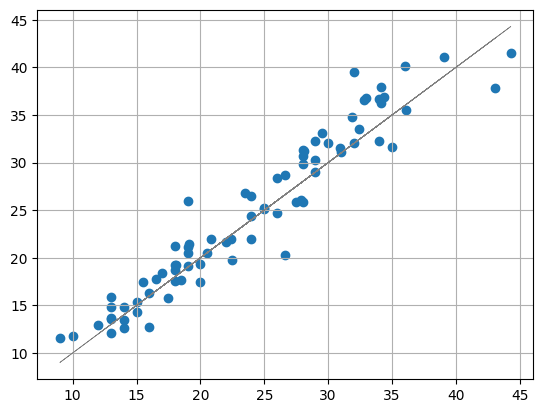

In [32]:
pred2_3 = best_model.predict(x_test, verbose = 0)
print('MAE :', mean_absolute_error(y_test, pred2_3))

plt.scatter(y_test, pred2_3)
plt.plot(y_test, y_test, color = 'gray', linewidth = .5)
plt.grid()
plt.show()